<a id="top_page"></a>
# Gaia Data

This is a jupyter notebook to explore gaia data. 

In [1]:
import astropy.units as u
from astropy.table import Table
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.vizier import Vizier
from astroquery.gaia import Gaia
from reference_finder import reference_finder

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.stats import gaussian_kde
import time
import warnings
warnings.filterwarnings('ignore')

### List Available Tables and columns 

In [3]:
tables = Gaia.load_tables(only_names=True)
table_list=[]
for table in (tables):
        if not "tap_schema" in table.name:        
            table = {'name': table.name, 'description': table.description}
            table_list.append(table)
Table(table_list).show_in_notebook(display_length=10)

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


idx,name,description
0,external.apassdr9,"The AAVSO Photometric All-Sky Survey - Data Release 9\n This publication makes use of data products from the AAVSO\n Photometric All Sky Survey (APASS). Funded by the Robert Martin Ayers\n Sciences Fund and the National Science Foundation. Original catalogue released by Henden et al. 2015 AAS Meeting #225, id.336.16. Data retrieved using the VizieR catalogue access tool, CDS, Strasbourg, France. The original description of the VizieR service was published in A&AS 143, 23. VizieR catalogue II/336."
1,external.gaiadr2_astrophysical_parameters,"Fouesneau et al. (2022) Gaia DR2 astrophysical parameters. ""Astrophysical Parameters from Gaia DR2, 2MASS & AllWISE"", Fouesneau et al., 2022, A&A (https://ui.adsabs.harvard.edu/abs/2022arXiv220103252F/abstract). Data replicated from the gdr2ap.main table at the GAVO Data Centre TAP service https://dc.g-vo.org/tap and TAP metadata as of January 2022.\n\nOriginal table description: Stellar physical and dynamical properties are essential knowledge to understanding the structure, formation, and evolution of our Galaxy. We produced an all-sky uniformly derived catalog of stellar astrophysical parameters (APs; age, mass, temperature, bolometric luminosity, distance, dust extinction) to give insight into the physical properties of Milky-Way stars. Exploiting the power of multi-wavelength and multi-survey observations from Gaia DR2 parallaxes and integrated photometry along with 2MASS and AllWISE photometry, we introduce an all-sky uniformly derived catalog of stellar astrophysical parameters, including dust extinction (A0) and average grain size (R0) along the line of sight, for 123,076,271 stars. In contrast with previous works, we do not use a Galactic model as prior in our analysis. We validate our results against other literature (e.g., benchmark stars, interferometry, Bayestar, StarHorse). The limited optical information in the Gaia photometric bands or the lack of ultraviolet or spectroscopic information renders the chemistry inference prior dominated. We demonstrate that Gaia parallaxes bring sufficient leverage to explore the detailed structures of the interstellar medium in our Milky Way. In Gaia DR3, we will obtain the dispersed optical light information to break through some limitations of this analysis, allowing us to infer stellar chemistry in particular. Gaia promises us data to construct the most detailed view of the chemo-dynamics of field star populations in our Galaxy."
2,external.gaiadr2_geometric_distance,"Estimating distances from parallaxes IV: Distances to 1.33 billion stars in Gaia Data Release 2. Bailer-Jones et al. 2018 AJ 156:58, https://doi.org/10.3847/1538-3881/aacb21. The catalogue provides distances estimates (and uncertainties therein) for 1.33 billion stars over the whole sky brighter than about G=20.7. These have been estimated using the parallaxes (and their uncertainties) from Gaia data release 2. A Bayesian procedure was used involving a prior with a single parameter L(l,b), which varies smoothly with Galactic longitude and latitude according to a Galaxy model. The posterior is summarized with a point estimate (usually the mode) and a confidence interval (usually the 68% highest density interval). The estimation procedure is described in detail in the accompanying paper, which also analyses the catalogue content. The catalogue comprises one table with 1.33 billion rows and seven columns. The accompanying paper explains under what circumstances the different estimates/modality occur. These should not be mixed in any statistical analyses. Around 99.9% of all sources have result_flag=1 and modality_flag=1."
3,external.gaiaedr3_distance,"\nBailer-Jones et al. (2021) EDR3 distances. <p> Estimating distances from parallaxes. V: Geometric and photogeometric distances to 1.47 billion stars in Gaia Early Data Release 3.\nBailer-Jones et al. 2021 AJ 161 147. Data replicated from gedr3dist.main table at GAVO Data Center TAP ser

In [4]:
def getTableColumns(tableName):
    table = Gaia.load_table(tableName)
    columns = []
    for c in table.columns:
        row = {"Name":c.name, "Description":c.description, "Unit": c.unit}
        columns.append(row)
    return(Table(columns))

In [5]:
columns = getTableColumns('gaiadr3.gaia_source')
columns.show_in_notebook()

Retrieving table 'gaiadr3.gaia_source'


idx,Name,Description,Unit
0,solution_id,Solution Identifier,
1,designation,Unique source designation (unique across all Data Releases),
2,source_id,Unique source identifier (unique within a particular Data Release),
3,random_index,Random index for use when selecting subsets,
4,ref_epoch,Reference epoch,yr
5,ra,Right ascension,deg
6,ra_error,Standard error of right ascension,mas
7,dec,Declination,deg
8,dec_error,Standard error of declination,mas
9,parallax,Parallax,mas


In case you need to look at the gaia data release documentation, you can do it [here](https://gea.esac.esa.int/archive/documentation/GDR2/Gaia_archive/chap_datamodel/sec_dm_main_tables/ssec_dm_gaia_source.html).

## Basic Terms used in the tables

*Parallax*: The parallax of an object is its observed angular displacement with respect to a reference frame due to the movement of the observer over a baseline.<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/7d/Stellarparallax_parsec1.svg/220px-Stellarparallax_parsec1.svg.png" /><br><br>

*Proper Motion*: The angular change in the position of a star across our line of sight is called proper motion. This is measured in arc serconds/year and is usually noted by $\mu$. The component of proper motion along DEC is denoted as $\mu_\delta$ and the proper motion along RA is denoted as $\mu_{\alpha✶}(\mu_{\alpha}\cos\delta)$ corrected for declination. Hence the proper motion is given by:$$\mu = \sqrt{{\mu^2}_{\alpha} - {\mu^2}_{\delta}}$$<img src="" />

*Tangential Velocity*: The real velocity across our line of sight is called tangential velocity. As proper motion is angular velocity we also need to know the star's distance to know the tangential velocity. It can be calculated from the following equation<br>

*Radial Velocity*:  The velocity which describes the motion of a star along our line of sight is called Radial velocity. A positive radial velocity indicates motion away from us and negative motion towards us.<br><br>


*Space Velocity*: The velocity and direction in which a star moves in space is called its space motion or space velocity (v). Space velocity is obtained by vector addition of the radial velocity ($v_r$)  and the tangential velocity ($v_t$) to give us the total space velocity ($v_s$) (​Fig 3​). The magnitude of space velocity (v) can be calculated using the Pythagoras theorem$$v_s = \sqrt{{v^2}_r + {v^2}_t}$$

*BP*: blue photometer (BP), handles wavelengths from 330 to 680 nm. <br>
*RP*: red photometer (RP), handles wavelengths from 640 to 1050nm<br>

## Cone Search

In [6]:
coord = SkyCoord(ra=280, dec=-60, unit=(u.degree, u.degree), frame='icrs')
radius = u.Quantity(1.0, u.deg)
j = Gaia.cone_search_async(coord, radius)
r = j.get_results()
r

INFO: Query finished. [astroquery.utils.tap.core]


solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,dist
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / mas2,1 / um,1 / um,,,,mas,,,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,solRad,solRad,solRad,solLum,solLum,solLum,,
int64,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int32,int16,bool,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,int32,float32,float32,float32,object,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,object,float64
1635721458409799680,Gaia DR2 6636090334814214528,6636090334814214528,1176213019,2015.5,280.0002535109784,0.29861262266219235,-60.00259470935402,0.3286090424553563,-0.3110984894867886,0.4659006859423401,-0.66773564,-0.3829646819799206,0.5485869545050303,-6.494624923325772,0.5631744832783001,0.14009339,-0.032677036,-0.040756915,0.1848471,-0.24814793,0.25431943,-0.020390274,-0.41731763,-0.023678254,0.053505838,273,0,272,1,2.0634625,316.8305,0.8687575596881527,0.8324284930248446,31,False,0.08247371,1.5682945669210009,0.10173123960452841,0.09272486,31,14,0.5277922,0,32,False,277,229.27686620684315,1.1770479415122068,194.78975,19.787466,29,132.09798809841195,9.236134667236668,14.302302,20.049149,25,169.83721262885817,6.933962725221738,24.493528,19.186838,1.3169022,0,0.8623104,0.2616825,0.6006279,--,--,0,--,--,--,NOT_AVAILABLE,335.4869899853897,-21.882743330467846,276.222852405146,-36.779152165694725,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,https://gea.esac.esa.int/data-server/datalink/links?ID=Gaia+DR2+6636090334814214528,0.00260346369939069
1635721458409799680,Gaia DR2 6636090339113063296,6636090339113063296,570813457,2015.5,280.0051165709225,0.050240754418698456,-59.9971106177236,0.05569779779421987,2.1445897979735338,0.08686626499655296,24.688408,-30.23913611

<a id="query"></a>
## Gaia ADQL Queries

Gaia ADQL query examples:
* [Astroquery Gaia Module](https://astroquery.readthedocs.io/en/latest/gaia/gaia.html)
* [An Astronomy Data Query Language cookbook to accompany Gaia Data Release 1](https://www.gaia.ac.uk/data/gaia-data-release-1/adql-cookbook)
* [Gaia Archive Use Cases](https://www.cosmos.esa.int/web/gaia-users/archive/use-cases)
* [Query Examples](https://www.cosmos.esa.int/web/gaia-users/archive/writing-queries)
* [https://www.judithirwin.com/assignment-1.html](https://www.judithirwin.com/assignment-1.html)
* [https://www.physik.uzh.ch/events/sf2019/tutorials/manual.pdf](https://www.physik.uzh.ch/events/sf2019/tutorials/manual.pdf)
* [http://www.euro-vo.org/sites/default/files/documents/tutorial-adql_2017Nov.pdf](http://www.euro-vo.org/sites/default/files/documents/tutorial-adql_2017Nov.pdf)

### A Colour Magnitude Diagram of M45

In [7]:
# Little bit of help for coordinates
def wikipediaCoordinates(ra,dec):
    '''A little function that translates coordinates from hour, minute, second format
    (which is usually displayed on wikipedia) to a degree format'''
    c = SkyCoord(ra,dec,frame='icrs')
    coords = c.to_string().replace(" ", ",")
    return coords

In [8]:
def getGaiaCMD(catalog, abs_mag, b_r, title, save_plot=False):
    """
    This function uses the results from a Gaia ADQL query as input and returns a 
    colour magnitude diagram for all the stars observed in that query.
    
    Dependencies: 
    numpy
    matplotlib.pyplot
    scipy.stats.gaussian_kde
            
    Parameters:
    catalog (astropy.table): The catalog to plot a colour magnitude diagram from.
    abs_mag (str): The name of the column with the absolute magnitude.
    b_r (str): The name of the column with the difference between the blue and red magnitude.
    title (str): The title of the colour magnitude plot
    save_plot (bool): A flag to save the figure. Defaults to false, to save the figure, change the flag to True
        
    Returns:
    ax(matplotlib.axes._subplots.AxesSubplot): A matplot axes object containing the colour magnitude diagram.
    """
    
    x = catalog[b_r]
    y = catalog[abs_mag]
    
    f, ax = plt.subplots(figsize=(8,8))
    ax.set_xlabel(f"{b_r}", fontsize=14)
    ax.set_ylabel(f"{abs_mag}", fontsize=14)
    ax.invert_yaxis()
    ax.set_title(title, size=14)
    plt.text(.12,.95,f'{len(x)} stars', horizontalalignment='center', transform=ax.transAxes, size=13)
    ax.scatter(x, y,c='r', marker='o',s=1)
    
    if save_plot:
        f.savefig(title.replace(" ", "_")+".png")
        print(title.replace(" ", "_")+".png"+" saved.")
    return ax

In [9]:
# Basic ADQL Query: SELECT <Columns> FROM <Table> WHERE <Constraints>
query = f"""
SELECT source_id,
    ra,
    dec,
    phot_g_mean_mag + 5.0 * log10(parallax)- 10.0 AS g_mag_abs, 
    phot_bp_mean_mag,
    phot_rp_mean_mag,
    bp_rp
FROM gaiadr3.gaia_source
WHERE parallax_over_error >= 5
    AND phot_bp_mean_flux_over_error > 0
    AND phot_rp_mean_flux_over_error > 0
    AND CONTAINS(POINT('ICRS', ra, dec),CIRCLE('ICRS',{wikipediaCoordinates('03h47m24s', '+24d07m0s')},2.5))=1
"""
t0 = time.time()
job = Gaia.launch_job_async(query)
print(f"Query completed in {time.time()-t0} seconds.")
r = job.get_results()
r

INFO: Query finished. [astroquery.utils.tap.core]
Query completed in 103.19509315490723 seconds.


source_id,ra,dec,g_mag_abs,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp
,deg,deg,,mag,mag,mag
int64,float64,float64,float64,float32,float32,float32
65583742591605248,58.34476979558904,22.68822154645986,8.854216577461802,18.786692,16.543457,2.2432346
65583875733141632,58.365303818351805,22.71192161707213,6.715725928926503,18.560629,16.845654,1.7149754
65583914390253056,58.38356467886772,22.71418566431138,4.66842008166055,17.014826,15.9139,1.1009254
65583948747664384,58.34487909309278,22.701462961114416,10.069767973864874,17.94771,15.077742,2.8699684
65583948747956608,58.34034820287382,22.70151637201087,11.007287876740584,20.643658,17.811607,2.8320503
65583948749993216,58.34122508198289,22.695061552162862,7.043484954130502,14.414783,12.862484,1.5522985
65583983109731072,58.35195953258497,22.703621471576263,4.138092759114258,14.187797,13.039414,1.1483822
...,...,...,...,...,...,...


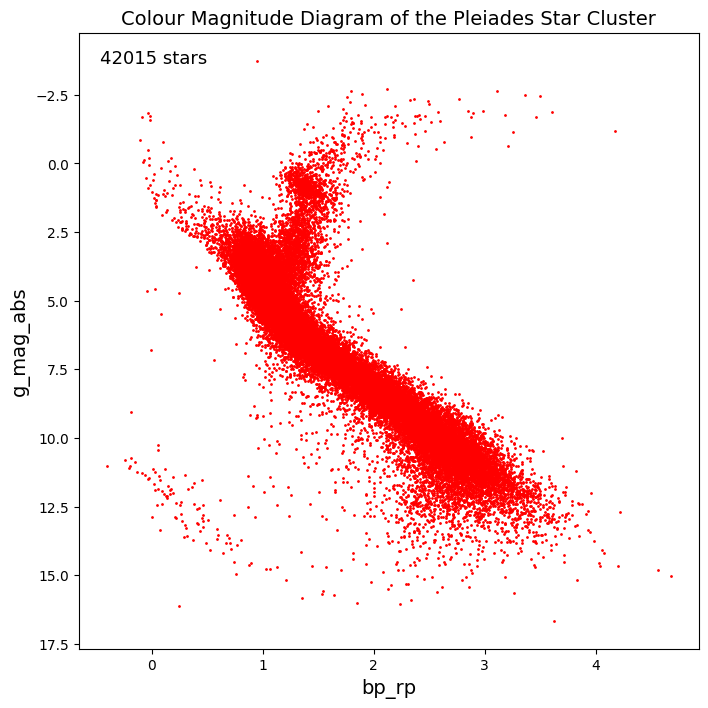

In [10]:
cmd = getGaiaCMD(r,
                 'g_mag_abs', 
                 'bp_rp', 
                 f"Colour Magnitude Diagram of the Pleiades Star Cluster")

Text(0.5, 1.0, '')

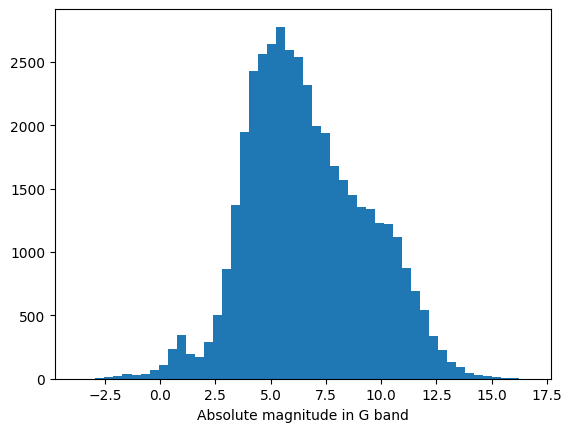

In [11]:
plt.hist(list(r['g_mag_abs']), bins=50)
plt.xlabel('Absolute magnitude in G band')
plt.title('')

## About this Notebook
**Author:** Mikhail Martins<br>
**Last Updated on:** 25th January, 2023

[Top of Page](#top_page)<br>
[ADQL Query](#query)